This is the second in a series of posts which constitute a "lit review" of sorts, documenting the range of methods scholars are using to compute the distribution of topics over time.

Graphs of topic prevalence over time are some of the most ubiquitous in digital humanities discussions of topic modeling. They are used as a mechanism for identifying spikes in discourse and for depicting the relationship between the various discourses in a corpus.

Topic prevalence over time is not, however, a measure that is returned with the standard modeling tools such as MALLET or Gensim. Instead, it is computed after the fact by combining the model data with external metadata and aggregating the model results. And, as it turns out, there are a number of ways that the data can be aggregated and displayed.
In this series of notebooks, I am looking at 4 different strategies for computing topic significance over time. These strategies are:

+ [Average of topic weights per year (First Post)](http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/)
+ Smoothing or regression analysis
+ Prevalence of the top topic per year
+ Proportion of total weights per year


To explore a range of strategies for computing and visualizing topics over time from a standard LDA model, I am using a model I created from my dissertation materials. You can download the files needed to follow along from https://www.dropbox.com/s/9uf6kzkm1t12v6x/2017-06-21.zip?dl=0.

In [1]:
# Load the necessary libraries
from ggplot import *
import json
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd # Note: I am running 0.19.2
import pyLDAvis.gensim
import seaborn as sns
import warnings

In [2]:
# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()

In [3]:
# Temporary fix for persistent warnings of an api change between pandas and seaborn.
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_rows = 10

In [5]:
base_dir = "data"
period = '1859-to-1875'
directory = "historical_periods"

# Create the dataframes

In [6]:
metadata_filename = os.path.join(base_dir,'2017-05-corpus-stats/2017-05-Composite-OCR-statistics.csv')
index_filename = os.path.join(base_dir, 'corpora', directory, '{}.txt'.format(period))
labels_filename = os.path.join(base_dir, 'dataframes', directory, '{}_topicLabels.csv'.format(period))
doc_topic_filename = os.path.join(base_dir, 'dataframes', directory, '{}_dtm.csv'.format(period))

In [7]:
def doc_list(index_filename):
    """
    Read in from a json document with index position and filename. 
    File was created during the creation of the corpus (.mm) file to document
    the filename for each file as it was processed.
    
    Returns the index information as a dataframe.
    """
    with open(index_filename) as data_file:    
        data = json.load(data_file)
    docs = pd.DataFrame.from_dict(data, orient='index').reset_index()
    docs.columns = ['index_pos', 'doc_id']
    docs['index_pos'] = docs['index_pos'].astype(int)
  
    return docs


def compile_dataframe( index, dtm, labels, metadata):
    """
    Combines a series of dataframes to create a large composit dataframe.
    """
    doc2metadata = index.merge(metadata, on='doc_id', how="left")
    topics_expanded = dtm.merge(labels, on='topic_id')
    
    df = topics_expanded.merge(doc2metadata, on="index_pos", how="left")
    
    return df

In [8]:
metadata = pd.read_csv(metadata_filename, usecols=['doc_id', 'year','title'])
docs_index = doc_list(index_filename)
dt = pd.read_csv(doc_topic_filename)
labels = pd.read_csv(labels_filename)

The first step, following the pattern of [Andrew Goldstone for his topic model browser](https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R#L373-L415), is to normalize the weights for each document, so that they total to "1".

As a note, Goldstone first smooths the weights by adding the alpha hyperparameter to each of the weights, which I am not doing here.

In [9]:
# Reorient from long to wide
dtm = dt.pivot(index='index_pos', columns='topic_id', values='topic_weight').fillna(0)

# Divide each value in a row by the sum of the row to normalize the values
dtm = (dtm.T/dtm.sum(axis=1)).T

# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']

In [10]:
df = compile_dataframe(docs_index, dt_norm, labels, metadata)

In [11]:
df

,index_pos,topic_id,norm_topic_weight,topic_words,doc_id,year,title
0,0,0,0.045525,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page1.txt,1863,GCB
1,1,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page2.txt,1863,GCB
2,2,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page3.txt,1863,GCB
3,3,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page4.txt,1863,GCB
4,4,0,0.000000,"satan, salvation, sinner, righteousness, peace...",GCB186305XX-VXX-XX-page5.txt,1863,GCB
...,...,...,...,...,...,...,...
288595,11539,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page4.txt,1872,YI
288596,11540,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page5.txt,1872,YI
288597,11541,24,0.000000,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page6.txt,1872,YI
288598,11542,24,0.012192,"jerusalem, thess, parable, lazarus, thou_hast,...",YI18721201-V20-12-page7.txt,1872,YI


# Data dictionary:

+ `index_pos` : Gensim uses the order in which the docs were streamed to link back the data and the source file. `index_pos` refers to the index id for the individual doc, which I used to link the resulting model information with the document name.
+ `topic_id` : The numerical id for each topic. For this model, I used 20 topics to classify the periodical pages.
+ `norm_topic_weight` : The proportion of the tokens in the document that are part of the topic, normalized per doc.
+ `topic_words` : The top 6 words in the topic.
+ `doc_id` : The file name of the document. The filename contains metadata information about the document, such as the periodical title, date of publication, volume, issue, and page number.
+ `year` : Year the document was published (according to the filename)
+ `title` : Periodical that the page was published in.

In [12]:
order = ['conference, committee, report, president, secretary, resolved',
         'quarterly, district, society, send, sept, business',
         'association, publishing, chart, dollar, xxii, sign',
         'mother, wife, told, went, young, school',
         'disease, physician, tobacco, patient, poison, medicine',
         'wicked, immortality, righteous, adam, flesh, hell',
        ]

In [13]:
def create_plotpoint(df, y_value, hue=None, order=order, col=None, wrap=None, size=6, aspect=2, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

# Smoothing or Regression Analysis

The second popular topic visualization strategy I found is using a smoothing function to highlight trends in the data. I found this strategy was most commonly executed through the graphing library (rather than computing prior to graphing). 

The prime example is using the `geom_smooth` option in ggplot. This is a little harder to do with Seaborn, but fortunately there is a Python port of ggplot so I can demonstrate on my model. For the sake of simplicity, and because faceting with the Python version is buggy, I will work with only one topic at a time for this experiment.

In [14]:
t17 = df[df['topic_id']== 17]

The `loess` smoother is particularly designed for extrapolating trends in timeseries and noisy data, and is the default smoother in ggplot for data samples with fewer than 1000 observations. The `gam` smoother is the default for larger datasets.[^1] While I have more than 1000 observations, I will use both to illustrate the differences.

[^1]: http://ggplot2.tidyverse.org/reference/geom_smooth.html

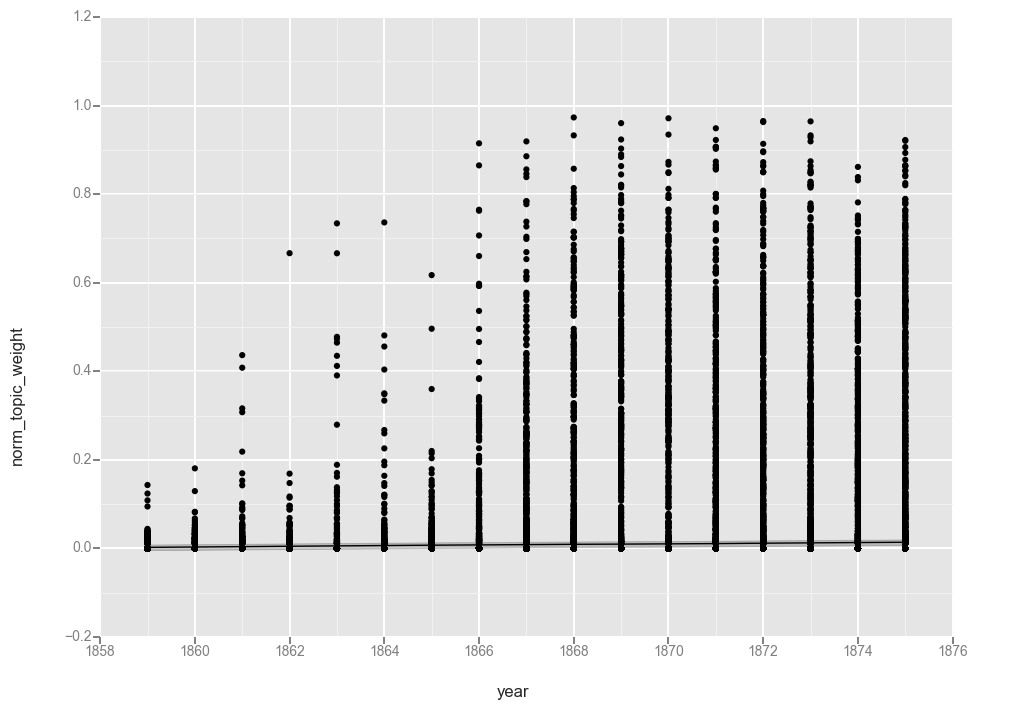

<ggplot: (287572516)>

In [15]:
ggplot(t17, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='loess')

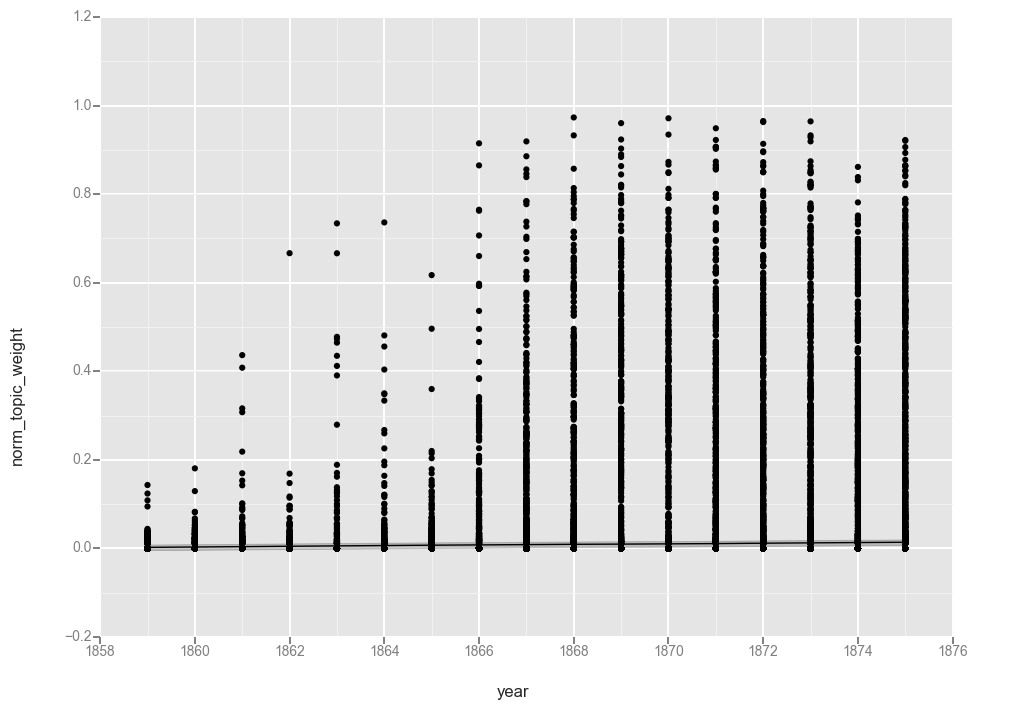

<ggplot: (-9223372036567940983)>

In [16]:
ggplot(t17, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='gam')

The collection of "0" values appears to have caused the function to flatline at "0" so let's filter those out (cringing as we do, because now the total number of observations each year will vary). If you are using data produced by MALLET you might not have this problem. But someone else can experiment with that.

In [17]:
# Drop all rows where the topic weight is 0
t17f = t17[t17['norm_topic_weight'] > 0]

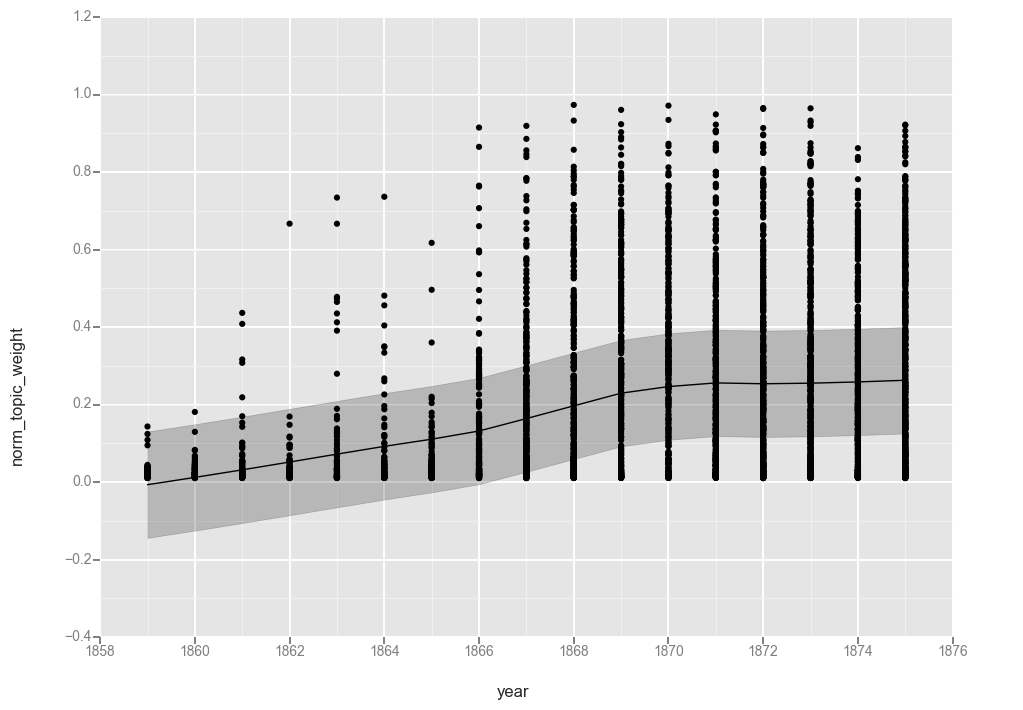

<ggplot: (287168092)>

In [18]:
ggplot(t17f, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='loess')

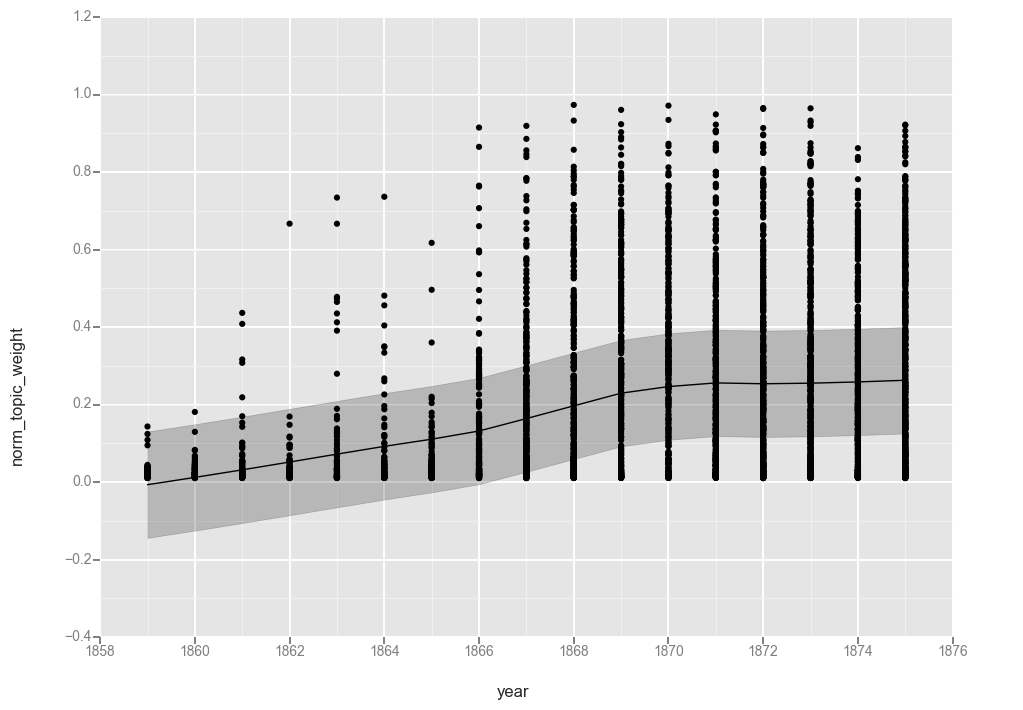

<ggplot: (287167152)>

In [19]:
ggplot(t17f, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='gam')

While not quite as pretty as the graphs from R, these graphs help illustrate the calculations. 

The first observation is that the lines are functionally equivalent, so both smoothing functions found a similar line. 

Looking at the line, we see a gradual increase over the first 7 years of the dataset, a more rapid increase between 1866 and 1869, and then leveling off at around 25% for the rest of the period. That matches what we saw when charting averages in the last post, though it hides the variations from year to year.

Topic 17, or "disease, physician, tobacco, patient, poison, medicine" was a topic with a large shift in our corpus, so for comparison, let us look at a more typical topic.

Topic 20: "mother, wife, told, went, young, school"

In [20]:
t20 = df[df['topic_id'] == 20]

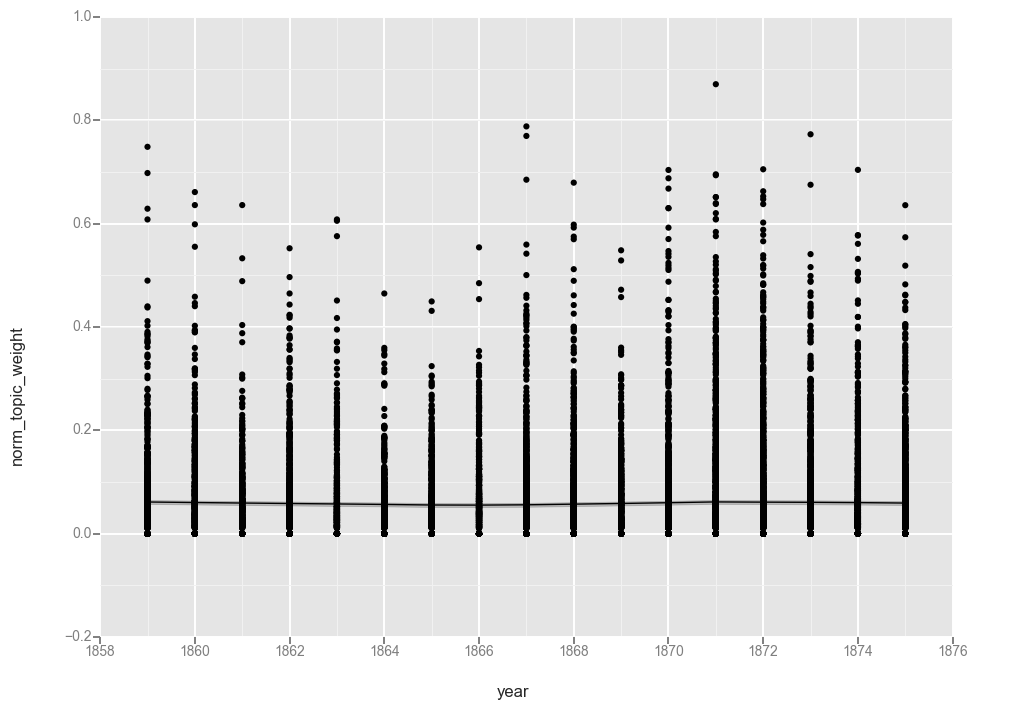

<ggplot: (-9223372036567088787)>

In [21]:
ggplot(t20, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='loess')

My best guess as to why the unfiltered topic 20 does not flatline at "0" where topic 17 did is that while health topics are either present or not on a page (and so have a high proportion of "0" value documents), "mother, wife, told, went, young, school" is a recurring feature of most pages in a given year. 

This could indicate that we need more topics in our model. But it also suggests something interesting about the language of the denomination that this topic is consistently part of the conversation.

In [22]:
t20f = t20[t20['norm_topic_weight'] > 0]

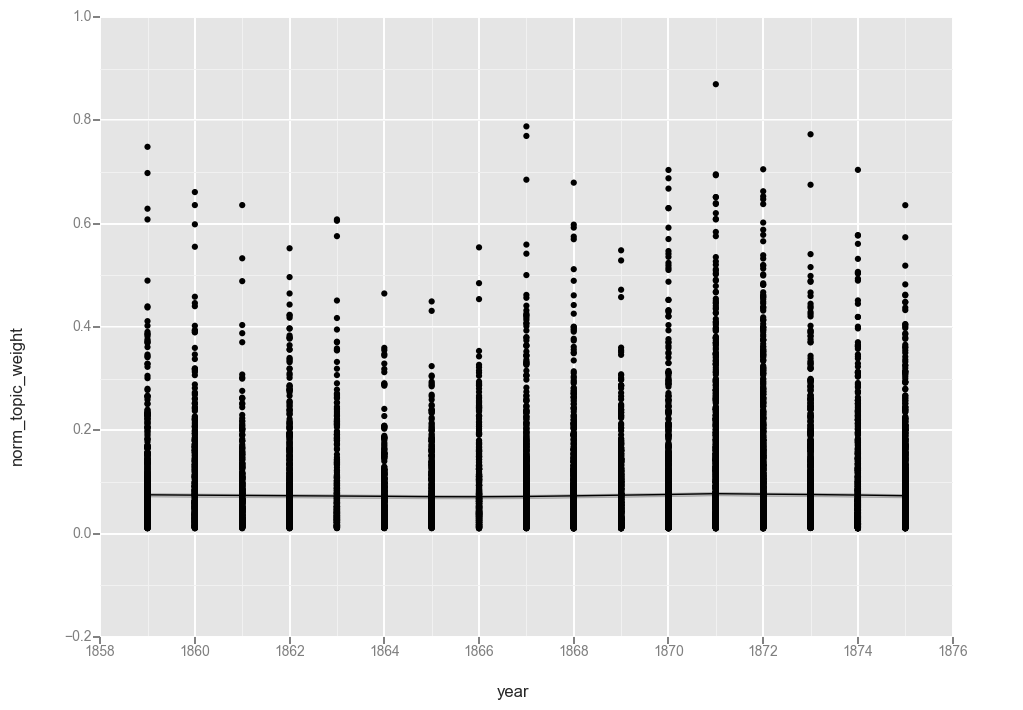

<ggplot: (288187824)>

In [23]:
ggplot(t20f, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='loess')

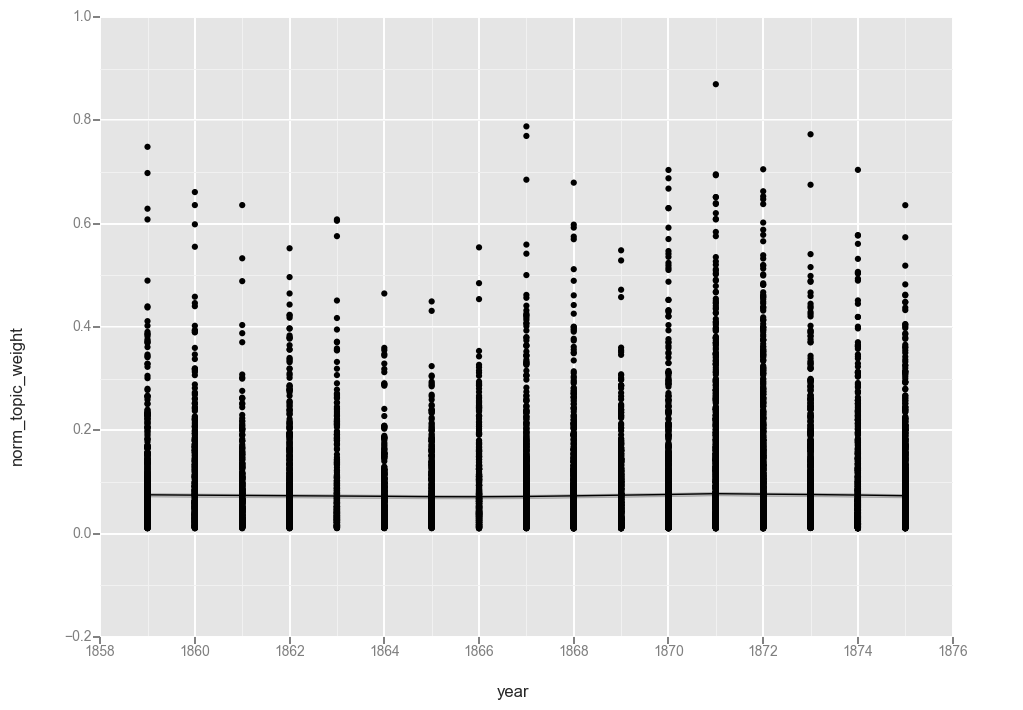

<ggplot: (-9223372036566588149)>

In [24]:
ggplot(t20f, aes(x='year', y='norm_topic_weight')) + geom_point() + stat_smooth(method='gam')

While removing the "0" values did result in moving the line up ever so slightly, the overall pattern is the same.

## Rolling Averages

While smoothing uses linear regression to identify trend lines, another strategy for computing the overall trajectory of a topic is to visualize the average on a rolling time window (such as computing the 5 year average.) This approach  emphasizes longer term patterns in topic weight. An example of this can be seen in the work of John Laudun and Jonathan Goodwin in "[Computing Folklore Studies: Mapping over a Century of Scholarly Production through Topics](muse.jhu.edu/article/524280)."[^2]

[^2]: John Laudun and Jonathan Goodwin. "Computing Folklore Studies: Mapping over a Century of Scholarly Production through Topics." Journal of American Folklore 126, no. 502 (2013): 455-475. [https://muse.jhu.edu/](https://muse.jhu.edu/) (accessed June 23, 2017).

Computing average over time is one calculation I struggled to work with. Back in Part 1, I mentioned that one of the big differences between the output from MALLET and Gensim is while Mallet returns a weight for every topic in every document, Gensim filters out the weights under 1%. Depending on how you handle the data, that can drastically effect the way averages are computed. If you have a weight for all topics in documents, then the average is over the whole corpus. If you only have weights for the significant topic assignments, things get wonky really fast.

Since we "inflated" our dataframe to include a "0" topic weight for all missing values in the Gensim output, the denominator for all of our averages is the same. That being the case, I believe we can compute the rolling mean by taking the average each year and then using the `rolling_mean` function in Pandas to compute the average across them.

In [25]:
# Group the data by year and compute the mean of the topic weights
t17grouped = t17.groupby('year')['norm_topic_weight'].mean()

# Compute the rolling mean per year and rename the columns for graphing.
t17rolling = pd.rolling_mean(t17grouped, 3).reset_index()
t17rolling.columns = ['year', 'rolling_mean']

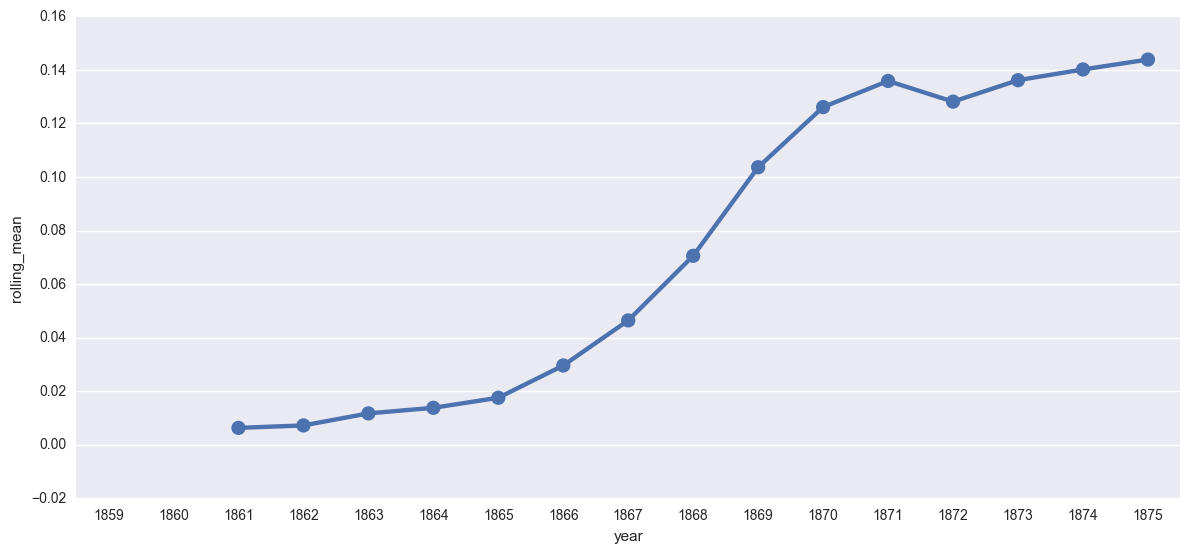

In [26]:
create_plotpoint(t17rolling, 'rolling_mean')

One thing to keep in mind is that both the linear smoothing and the rolling mean are strategies developed particularly for timeseries data, or data that is produced on regular intervals by some recording instrument. While an individual journal might be released on a semi-regular schedule, once we are working across multiple publications, this gets much more complicated. Because I don't have "real" timeseries data, I am hesitant about this approach.

Both the smoothing function in ggplot and the use of a rolling mean are methods for capturing the overall trend of a topic over time. In some ways, this feels like the holy grail metric — we are computing the trajectory of a particular discourse. But it is also an even more abstracted depiction of the topic weights than we drew when computing the averages. In describing his choice of bars to represent topic prevalence in a given year, Goldstone notes "I have chosen bars to emphasize that the model does not assume a smooth evolution in topics, and neither should we; this does make it harder to see a time trend, however."[^3] 

Both the smoothing function and the rolling mean are strategies for minimizing the dips and spikes of a particular year. If your question relates to the long-term trend of a topic (assuming your document base can support it), that is its advantage. But if your question is about discourse at a particular point or smaller period of time, then that is the weakness.

[^3]: https://agoldst.github.io/dfr-browser/

Next up: topic prevalence, in an epidemiology sort of way.